<a href="https://colab.research.google.com/github/ratusilma/Model-Pokemon-Dengan-Transformer/blob/main/Model_Pokemon_dengan_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]
Memulai Pelatihan...
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 6.9790
Menghasilkan Pokemon untuk: 'a pink cute pokemon'...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


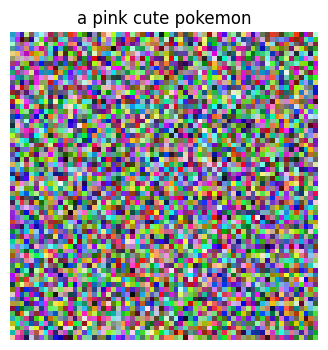

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset

# ==========================================
# Langkah 1: Persiapan Library & Load Dataset
# ==========================================
print("Memuat dataset...")
# Menggunakan subset kecil (train) untuk demonstrasi
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")

# Ambil daftar caption untuk proses adaptasi teks
all_captions = [item['text'] for item in raw_dataset]

# ==========================================
# Langkah 2: Inisiasi & Adaptasi Text Vectorization
# ==========================================
max_tokens = 5000
seq_len = 20
text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
)

# Proses Adapt (Mempelajari kosakata dari dataset)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

# ==========================================
# Langkah 3: Membangun Pipeline Data
# ==========================================
def preprocess_fn(item):
    # Proses Gambar: Ubah ke RGB, resize, dan normalisasi
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0
    # Proses Teks
    caption = item['text']
    return caption, image

def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

# Membuat tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)

# Batching dan Transformasi Teks ke Angka
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

# ==========================================
# Langkah 4: Definisi Model (Dummy Transformer)
# ==========================================
def get_transformer_model(vocab_size, visual_vocab_size=1024):
    text_input = layers.Input(shape=(seq_len,), dtype="int32")
    vis_input = layers.Input(shape=(255,), dtype="int32") # sequence visual (16x16 - 1)

    # Embedding Teks
    text_emb = layers.Embedding(vocab_size, 128)(text_input)
    # Embedding Visual
    vis_emb = layers.Embedding(visual_vocab_size, 128)(vis_input)

    # Gabungkan (Concatenate)
    combined = layers.Concatenate(axis=1)([text_emb, vis_emb])

    # Transformer Block Sederhana
    x = layers.MultiHeadAttention(num_heads=4, key_dim=128)(combined, combined)
    x = layers.LayerNormalization()(x + combined)

    # Ambil bagian visual saja untuk prediksi (output 255 token berikutnya)
    # Di sini kita sederhanakan outputnya langsung ke visual_vocab_size
    output = layers.Dense(visual_vocab_size)(x[:, seq_len:, :])

    return keras.Model([text_input, vis_input], output)

# Inisialisasi Model
transformer_model = get_transformer_model(len(vocab))

class PokemonTrainer(keras.Model):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data
        batch_size = tf.shape(images)[0]

        # 1. Simulasi Token Visual (Dalam aplikasi asli, gunakan VQ-VAE Encoder)
        # Kita anggap gambar 64x64 menjadi grid 16x16 = 256 token
        visual_tokens = tf.random.uniform((batch_size, 256), minval=0, maxval=1024, dtype=tf.int32)

        # 2. Siapkan input dan target (Autoregressive)
        vis_input = visual_tokens[:, :-1]  # Token 0 sampai 254
        vis_target = visual_tokens[:, 1:]   # Token 1 sampai 255 (yang akan diprediksi)

        with tf.GradientTape() as tape:
            # Prediksi
            preds = self.transformer([text_tokens, vis_input], training=True)
            # Hitung Loss
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)

        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# Inisialisasi dan Compile
trainer = PokemonTrainer(transformer_model)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

# Jalankan Training
print("Memulai Pelatihan...")
# Kita jalankan 1 epoch saja untuk demonstrasi cepat
trainer.fit(train_ds.take(5), epochs=1)

# ==========================================
# Langkah 5: Pengujian (Inference)
# ==========================================
def generate_image_tokens(model, text_tokens, length=256, vocab_size=1024):
    # Memulai dengan token kosong (zeros)
    generated_tokens = np.zeros((1, length), dtype="int32")
    for i in range(length - 1):
        # Prediksi token berikutnya
        preds = model.predict([text_tokens, generated_tokens[:, :-1]], verbose=0)
        next_token = np.argmax(preds[0, i, :])
        generated_tokens[0, i+1] = next_token
    return generated_tokens

def decode_to_real_image(tokens):
    # Dummy decoder: Mengubah token kembali ke bentuk gambar 64x64
    # Dalam sistem nyata, ini adalah tugas VQ-VAE Decoder
    return np.random.rand(64, 64, 3)

def generate_pokemon(prompt):
    print(f"Menghasilkan Pokemon untuk: '{prompt}'...")
    # 1. Ubah teks ke angka
    tokenized_text = text_vectorizer([prompt])
    # 2. Generate token visual
    gen_vis_tokens = generate_image_tokens(transformer_model, tokenized_text, 256, 1024)
    # 3. Decode jadi Gambar
    final_image = decode_to_real_image(gen_vis_tokens)

    plt.figure(figsize=(4,4))
    plt.imshow(final_image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# TEST
generate_pokemon("a pink cute pokemon")